<a href="https://colab.research.google.com/github/jainilparikh/MusicStyleTransfer/blob/main/conv1DMusicStyle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import skimage
import os
from skimage import io
import scipy.io.wavfile
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

#download Libraries

In [ ]:
!pip install librosa --upgrade
!pip install pydub
!pip install --upgrade tensorflow-probability
!apt-get install ffmpeg
!pip install pygobject

     |████████████████████████████████| 184kB 4.2MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201376 sha256=609602e67e988b2519e89aa11b0ff020b8557a44ffc7f7bb21c4be0ac3cba59c
  Stored in directory: /root/.cache/pip/wheels/ee/10/1e/382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3
     |████████████████████████████████| 4.3MB 5.6MB/s 
  Found existing installation: tensorflow-probability 0.11.0
    Uninstalling tensorflow-probability-0.11.0:
      Successfully uninstalled tensorflow-probability-0.11.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


#Convert Music file to Spectrogram

In [ ]:
import librosa
import cv2
import scipy
import librosa.display
def loadMusic(path , songName):
  x, sr = librosa.load(path,duration=58.04)
  print(sr)
  X = librosa.stft(x,)
  spectrogram_librosa_db = librosa.power_to_db(X, ref=np.max)
  librosa.display.specshow(spectrogram_librosa_db, sr=sr, y_axis='log', x_axis='time')
  plt.title('Reference power spectrogram')
  plt.colorbar(format='%+2.0f dB')
  plt.tight_layout()
  plt.show()
  ## TO check if the music is laoded correctly
  val = librosa.griffinlim(X)  ## Change to griffin lim as the phase information is retained
  maxAmplitude = val.max()
  val = val / maxAmplitude;
  print(val)
  #val = np.rint(val).astype(np.int16)
  print(val.min())
  print(val.max())
  scipy.io.wavfile.write('/content/song ' + songName + '.wav',22050,val)


  X = np.array(X)
  print(X.shape)
  return X;

#Input style and content music from Drive

/usr/local/lib/python3.6/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


22050


/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


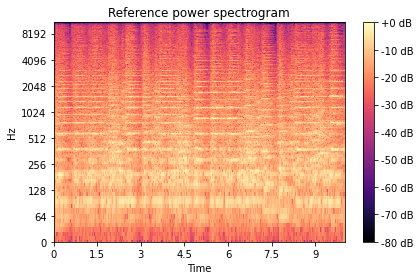

[-0.00107364 -0.00114534 -0.00075859 ... -0.11613405 -0.08204661
 -0.04745609]
-0.84530765
1.0
(1025, 431)


/usr/local/lib/python3.6/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


22050


/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


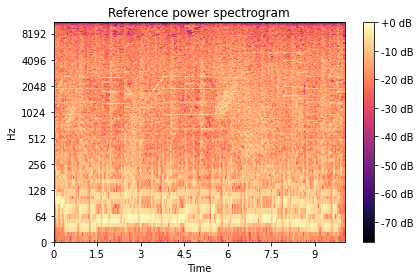

[-0.05669864  0.17060861  0.28314495 ...  0.23834178  0.16021246
 -0.02430114]
-1.1767915
1.0
(1025, 432)


In [ ]:
styleMusic = loadMusic("/content/drive/MyDrive/Nokia/mp3 data/data/imperial.mp3", "Style")
contentMusic = loadMusic("/content/drive/MyDrive/Nokia/mp3 data/data/futurama.mp3" , "Content")

# Shallow Random Nets

In [ ]:
StyleLossModel = tf.keras.models.Sequential();
StyleLossModel.add(tf.keras.layers.Conv1D(4096 , 3,strides = (1) ,padding = 'valid',kernel_initializer='random_uniform' , bias_initializer='random_uniform'))
StyleLossModel.add(tf.keras.layers.Activation(tf.keras.activations.relu))

## For Style Loss
def gramMatrix(inputImage):
  channels=int(inputImage.shape[-1])
  print("NUmber of channels : " + str(channels))
  a=tf.reshape(inputImage,[-1,channels])
  n=tf.shape(a)[0]
  print("Value of N : " + str(n))
  gram=tf.matmul(a,a,transpose_a=True)
  return(gram/tf.cast(n,tf.float32))

# Preprocessing Music files to correct format

In [ ]:

styleMusic = np.array(styleMusic).astype(np.float32)
styleMusic = np.reshape(styleMusic,(1 , styleMusic.shape[0] , styleMusic.shape[1]))
contentMusic = np.array(contentMusic).astype(np.float32)
contentMusic = np.reshape(contentMusic , (1 , contentMusic.shape[0] , contentMusic.shape[1]))       
contentMusic2 = np.zeros((contentMusic.shape[0] , contentMusic.shape[1] , styleMusic.shape[2]))
for i in range(contentMusic.shape[0]):
  for j in range(contentMusic.shape[1]):
    contentMusic2[i][j] = contentMusic[i][j][:styleMusic.shape[2]]
contentMusic = contentMusic2                 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


# Tensorflow Probablity Optimizer

In [ ]:
import functools
minimum =np.squeeze(styleMusic , axis = 0)
minimumContent = np.squeeze(contentMusic , axis = 0)
def make_val_and_grad_fn(value_fn):
  @functools.wraps(value_fn)
  def val_and_grad(x):
    print(lambda x: tf.reduce_sum(tf.math.squared_difference((x),(minimum)) , axis = -1))
    return tfp.math.value_and_gradient(lambda x: 2 *tf.reduce_sum(tf.math.squared_difference((x),(minimum)) +  2 * tf.math.squared_difference((x),(minimumContent))   , axis = -1), x)
  return val_and_grad

@make_val_and_grad_fn
def quadratic_loss_and_gradient(x):
  loss = tf.reduce_sum(x-minimum);
  loss = tf.reshape(loss , shape = (1,1))
  print(loss)
  return loss


# Loss Calculation and BackProp

In [ ]:
## Take into Consideration the content Image
import tensorflow_probability as tfp
def runFunction(contentMusic,styleMusic): 
  contentMusic = np.squeeze(contentMusic , axis = 0)
  print(contentMusic.shape)
  newMusic = np.random.randn(contentMusic.shape[0] , contentMusic.shape[1] )  # Random Tensor
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.03)
  maxImage = newMusic;
  maxCost = 1e12
  optimizer = tfp.optimizer.lbfgs_minimize(quadratic_loss_and_gradient , initial_position = newMusic,tolerance=1e-8 , max_iterations= 300)  
  print("Reached Here")
  return optimizer
  ## Weighted Loss calcualtion
  #for i in range(0,2500):  ####    Train till 500 steps
#    print('Iteration : ' + str(i))
#    with tf.GradientTape() as tape:
#      tape.watch(newMusic)
#      print(newMusic.shape)
#      loss1 = StyleLossModel(newMusic) 
#      loss2 = StyleLossModel(contentMusic)
#      loss3 = gramMatrix(StyleLossModel(styleMusic))
#      loss4 = gramMatrix(loss1);
#      contentLoss =   1e-4 * 2 * tf.nn.l2_loss((loss1 - loss2))
#      styleLoss =   tf.keras.losses.MSE(loss3,loss4); ## True Y value , Pred Y Value
      #loss  =tf.math.reduce_mean(styleLoss).numpy() ## Ignoring contentLoss for now as variable is initialized with content Music
#      loss = contentLoss + styleLoss
      #optimizer = tfp.optimizer.lbfgs_minimize(quadratic_loss_and_gradient , initial_position = newMusic,tolerance=1e-8)
#  return optimizer
 # gradient = tape.gradient(loss , newMusic);
  #optimizer.apply_gradients([(gradient,newMusic)])
#  return newMusic.numpy()

# Single Function Call to run Music Style Transfer

In [ ]:

newMusic = runFunction(contentMusic,styleMusic)

(1025, 431)
<function make_val_and_grad_fn.<locals>.val_and_grad.<locals>.<lambda> at 0x7ff3ac8ac6a8>
<function make_val_and_grad_fn.<locals>.val_and_grad.<locals>.<lambda> at 0x7ff3b76a4620>
<function make_val_and_grad_fn.<locals>.val_and_grad.<locals>.<lambda> at 0x7ff3ac808e18>
Reached Here


In [ ]:
print(newMusic.converged)
newMusic = newMusic.position

tf.Tensor([ True  True  True ...  True  True  True], shape=(1025,), dtype=bool)


# Convert resultant Music to correct Format

In [ ]:
print(newMusic.shape)
#newMusic = contentMusic
print(newMusic.shape)
#newMusic = np.reshape(newMusic , (newMusic.shape[1] , newMusic.shape[2]))

(1025, 431)
(1025, 431)


# PostProcessing(Spectrogram to Music File)

In [ ]:
print(newMusic)
val = librosa.griffinlim(newMusic.numpy())  ## Change to griffin lim as the phase information is retained
print(val.min())
print(val.max())
scipy.io.wavfile.write('/content/songOutput.wav',22050,val)

tf.Tensor(
[[ 8.22743171e+00  3.66977476e+00 -4.60341290e-01 ... -2.70470177e-01
  -3.94610882e-01 -2.67687927e-01]
 [-8.88567935e+00  7.19704965e-01  1.54718855e-01 ...  4.60909938e-01
  -1.27175264e-03  3.74930595e-01]
 [ 1.01960433e+01 -4.93129089e+00 -3.14025591e-01 ... -2.57410387e-01
   6.50727083e-01 -6.67579810e-01]
 ...
 [ 3.51822923e-02 -1.82980174e-02  1.25439311e-03 ...  7.55209575e-04
  -5.71902487e-04 -2.64017375e-05]
 [-3.45864551e-02  8.60523503e-04 -5.77621077e-04 ... -2.71644099e-04
   4.92997871e-04 -1.20658554e-05]
 [ 3.37465376e-02  1.66959608e-02  7.54322779e-06 ... -4.94453075e-04
  -3.24331810e-04  4.55097940e-04]], shape=(1025, 431), dtype=float64)
-0.12917908119092195
0.14210764663386913


# Adding Phase Infomation to resultant Music file ( Ignore for Now)

In [ ]:


print(styleMusic.shape)
print(contentMusic.shape)
a = np.zeros_like(newMusic)
a = np.exp(newMusic) - 1

In [ ]:
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
  print('iteration :' + str(i))
  S = a * np.exp(1j*p)
  x = librosa.istft(S)
  p = np.angle(librosa.stft(x,2048))

#scipy.io.wavfile.write('/content/songOutput2.wav',22050,x)